In [1]:
import numpy as np
import xarray as xr
import netCDF4
import os
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
import glob

In [2]:
data_dir = r"/home/raraki/waves/projects/smap-drydown/data"
datarod_dir = r"/home/raraki/waves/projects/smap-drydown/data/datarods"
rangeland_dir = "rangeland_resampled_linear"
shape = (406, 964)
width = shape[1]

# Get template EASE grid

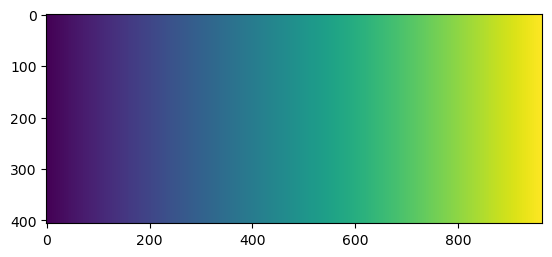

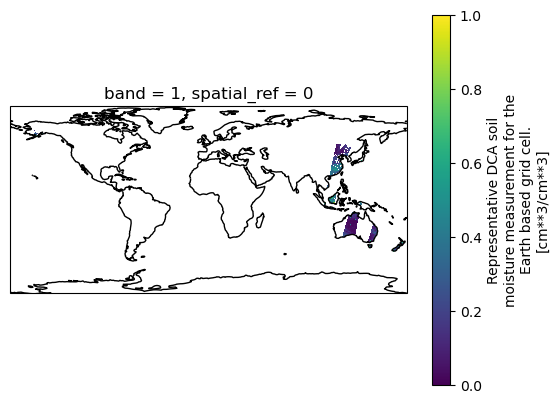

In [3]:
SMAPL3_grid_sample = r"/home/waves/projects/smap-drydown/data/SPL3SMP/SMAP_L3_SM_P_20150331_R18290_001.h5"
ncf = netCDF4.Dataset(SMAPL3_grid_sample, diskless=True, persist=False)
nch_am = ncf.groups.get('Soil_Moisture_Retrieval_Data_AM')
nch_pm = ncf.groups.get('Soil_Moisture_Retrieval_Data_PM')

# %%
# Return as regular numpy array rather than masked array
_latitude = ma.getdata(nch_am.variables['latitude'][:].filled(fill_value=np.nan), subok=True)
_longitude = ma.getdata(nch_am.variables['longitude'][:].filled(fill_value=np.nan), subok=True)
_EASE_column_index = ma.getdata(nch_am.variables['EASE_column_index'][:].astype(int).filled(fill_value=-1), subok=True)
_EASE_row_index = ma.getdata(nch_am.variables['EASE_row_index'][:].astype(int).filled(fill_value=-1), subok=True)

# %%
# Coordinates with no data are skipped --- fill them
latitude = np.nanmax(_latitude, axis=1)
EASE_row_index = np.nanmax(_EASE_row_index, axis=1)
longitude = np.nanmax(_longitude, axis=0)
EASE_column_index = np.nanmax(_EASE_column_index, axis=0)

EASE_row_index_expanded = np.tile(EASE_row_index, (len(EASE_column_index), 1)).T 
EASE_column_index_expanded = np.tile(EASE_column_index, (len(EASE_row_index), 1))
plt.imshow(EASE_column_index_expanded)

_ds_SMAPL3 = xr.open_dataset(SMAPL3_grid_sample, engine='rasterio', group='Soil_Moisture_Retrieval_Data_AM', variable=['soil_moisture'])
ds_SMAPL3_coord_template = _ds_SMAPL3.assign_coords({'x':longitude, 'y':latitude}).rio.write_crs("epsg:4326")

import cartopy.crs as ccrs
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': projection})
# Plot the new data
ds_SMAPL3_coord_template.sel(band=1).Soil_Moisture_Retrieval_Data_AM_soil_moisture.plot(ax=ax, transform=projection, vmin=0, vmax=1)
ax.coastlines()
plt.show()

# Import resampled data

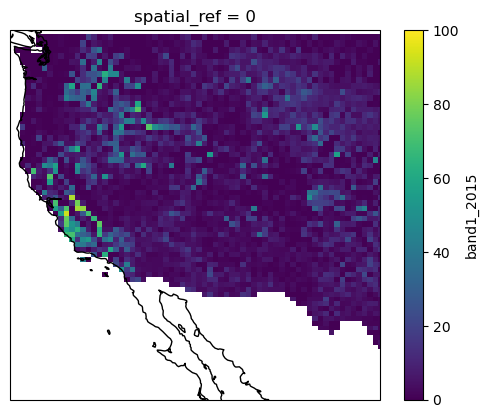

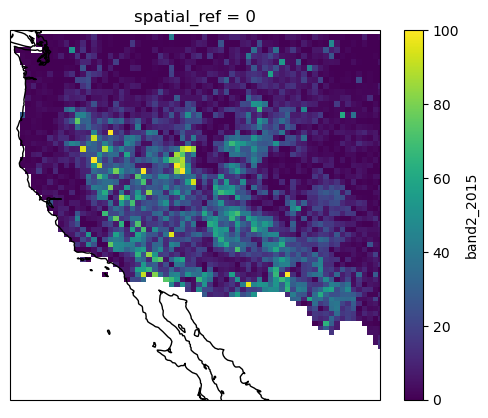

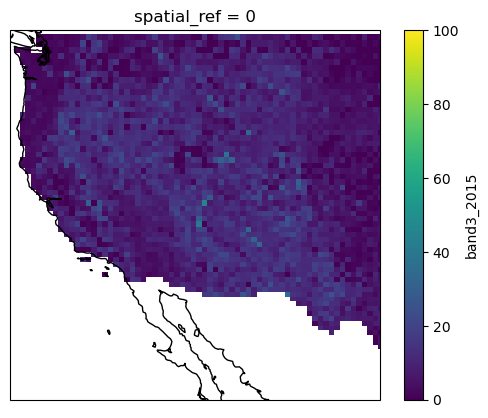

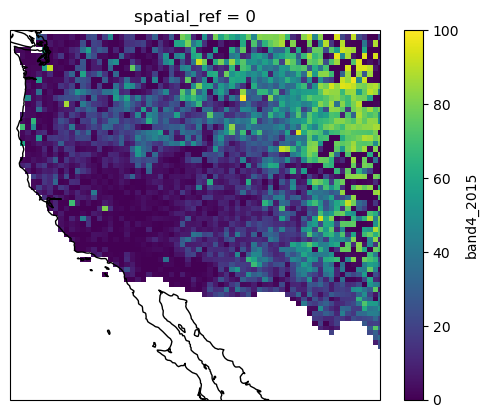

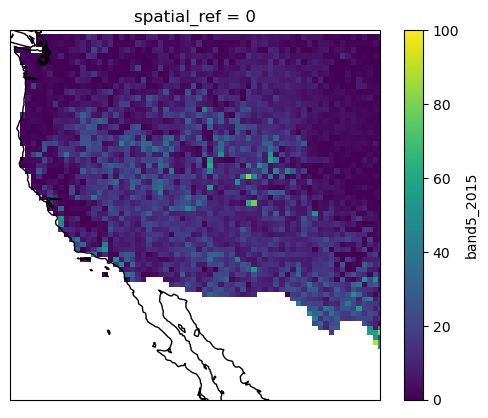

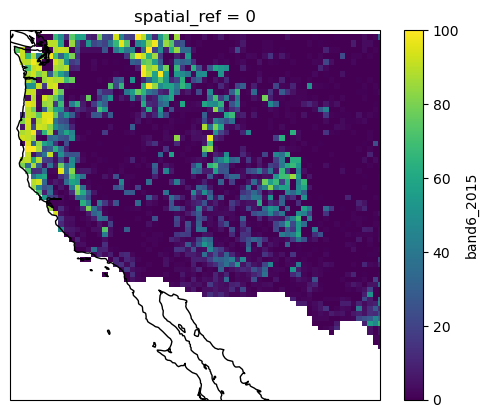

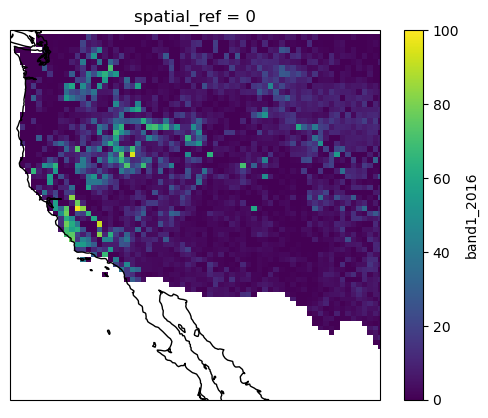

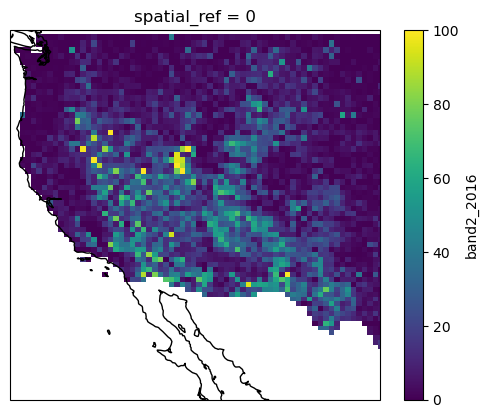

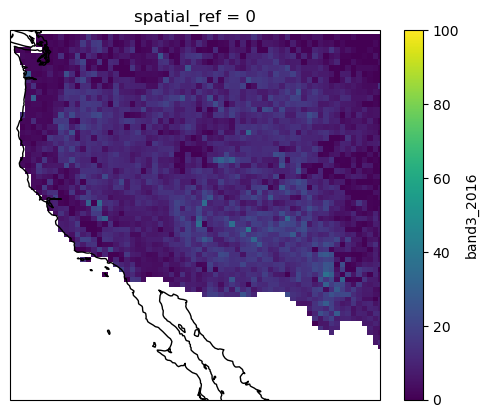

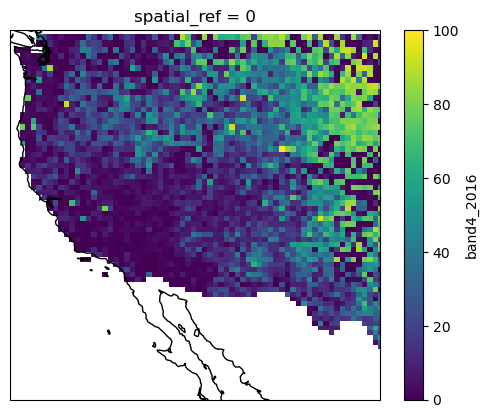

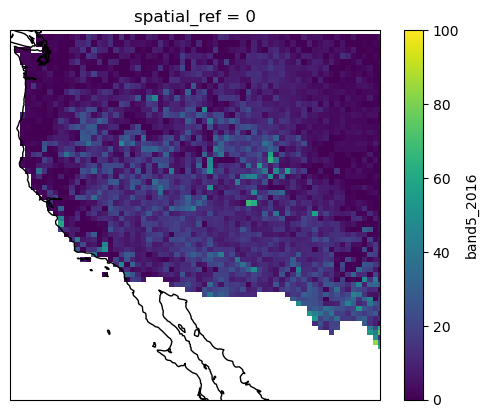

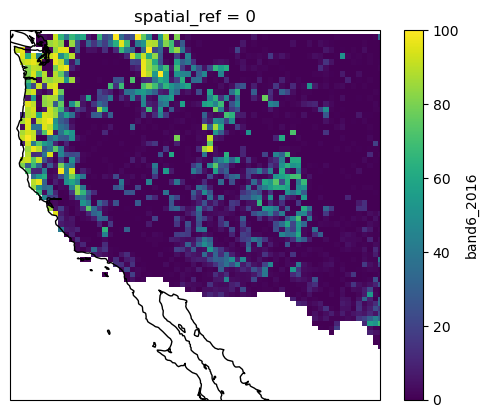

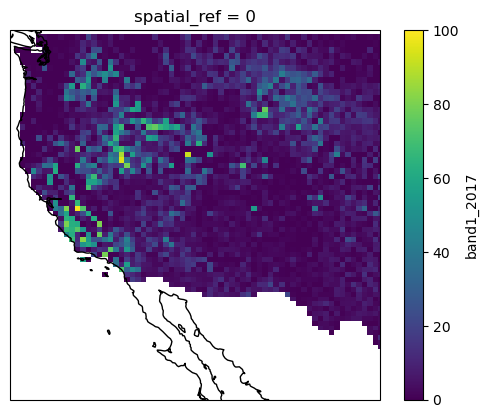

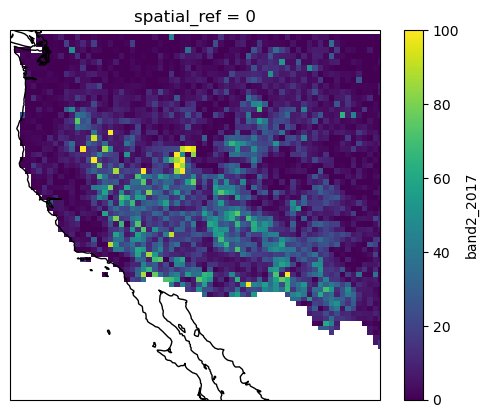

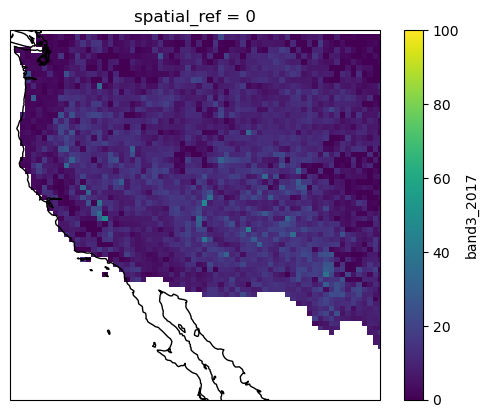

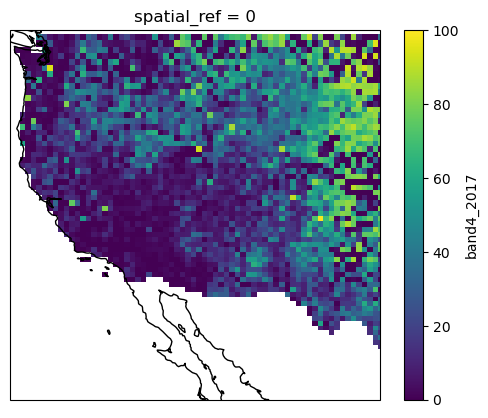

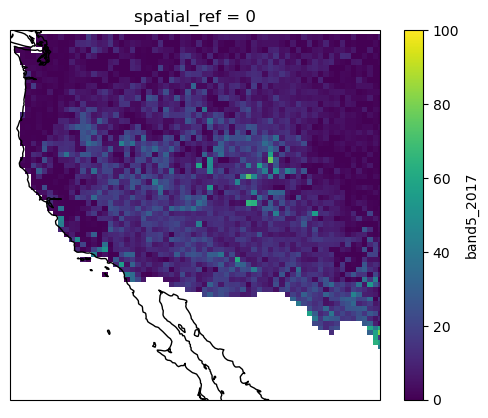

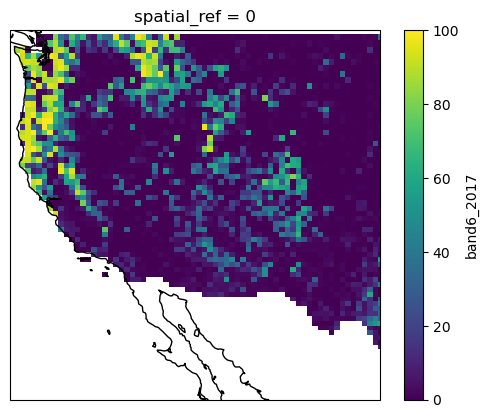

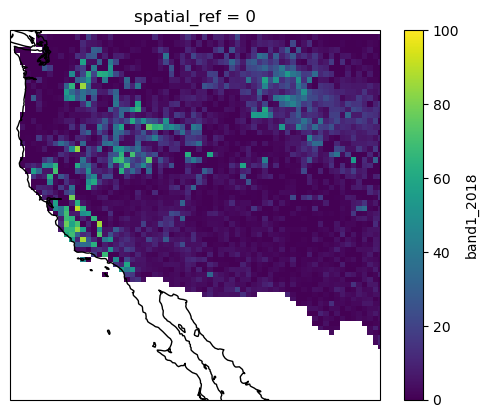

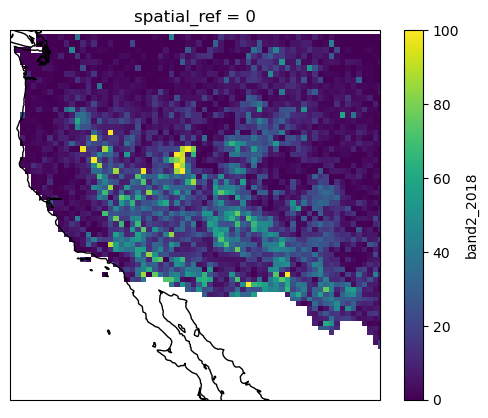

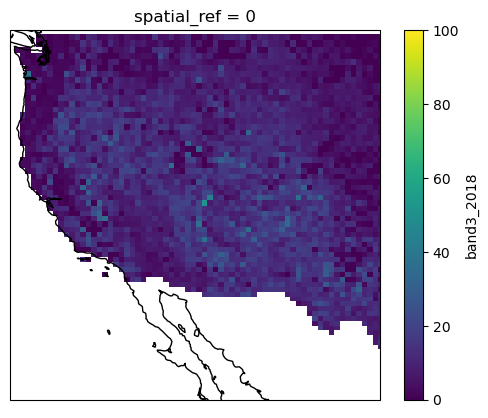

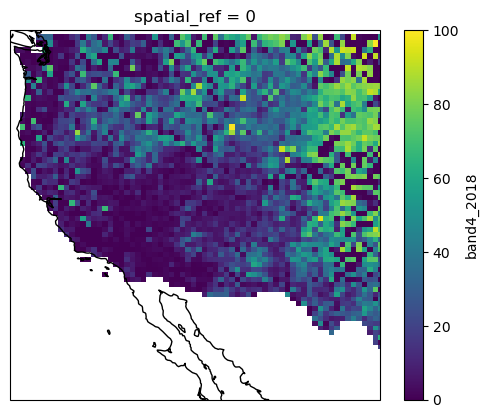

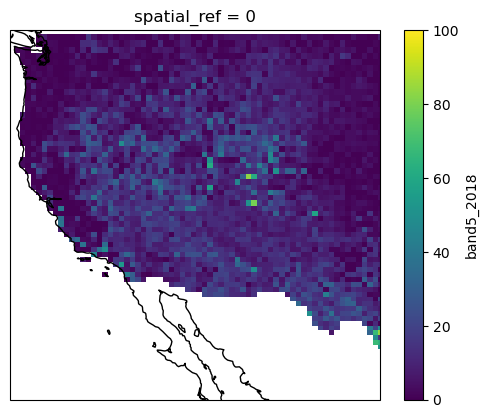

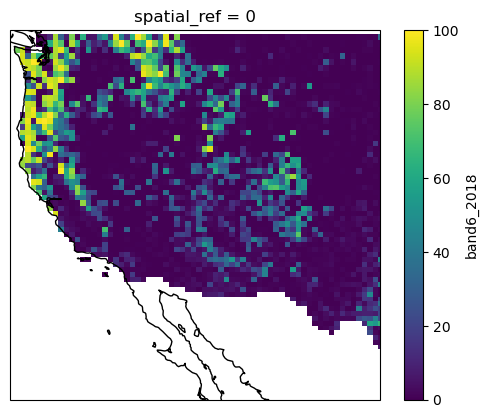

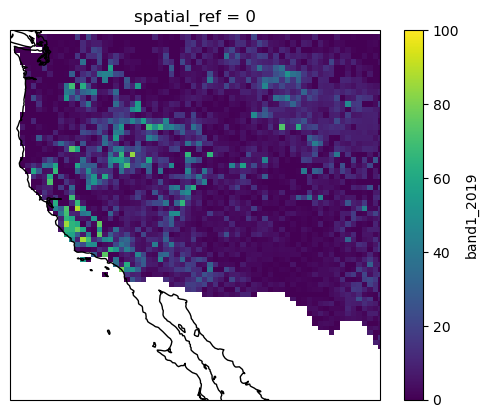

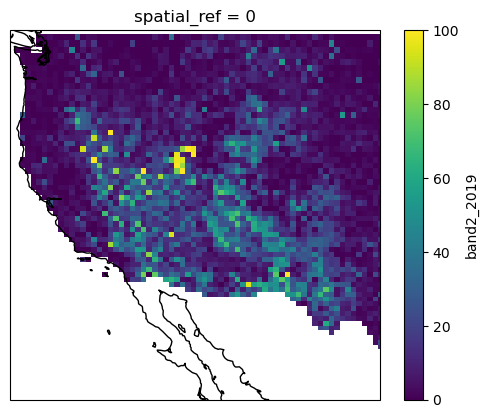

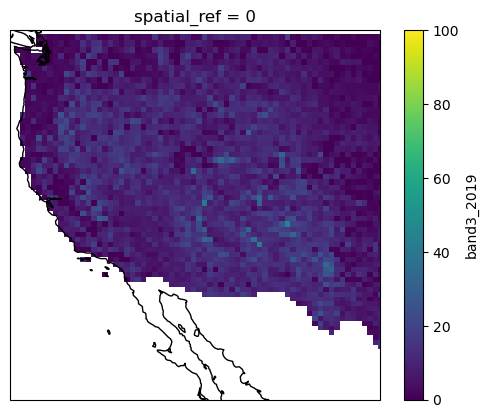

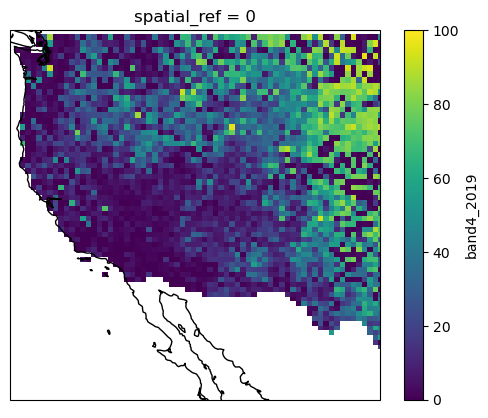

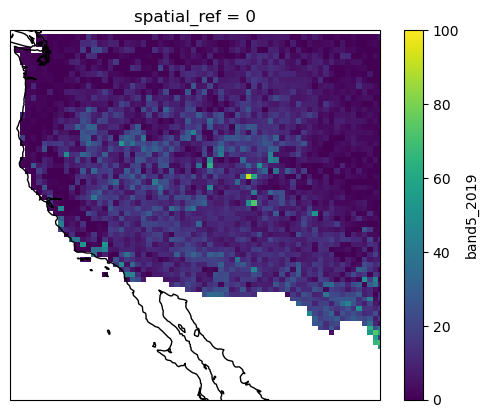

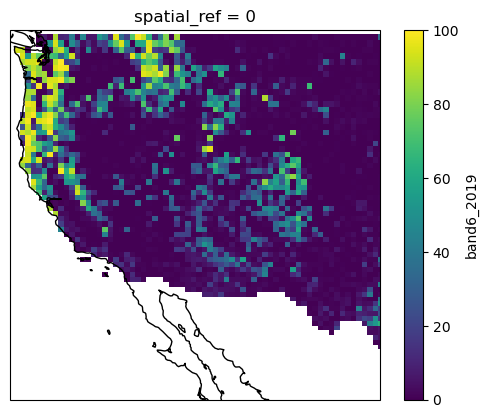

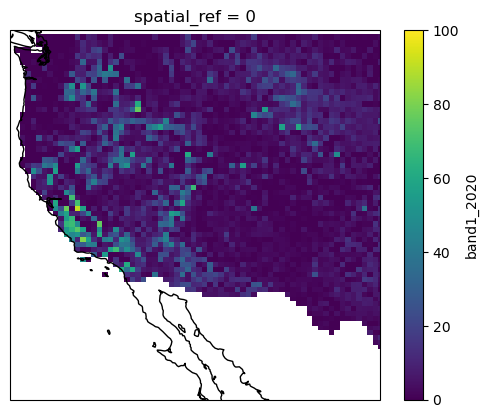

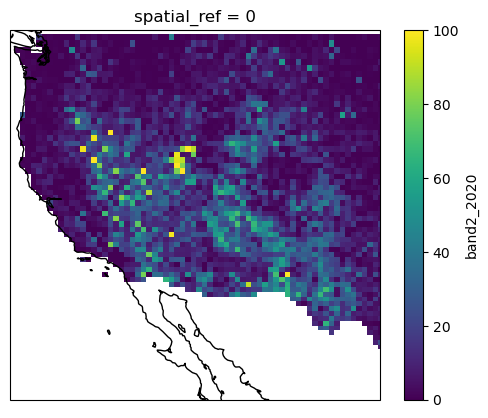

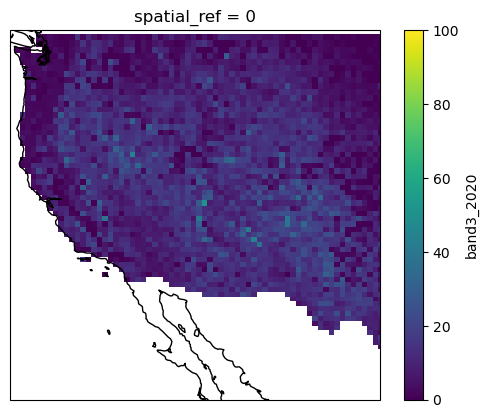

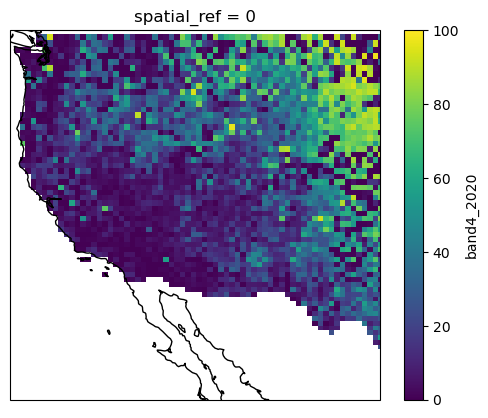

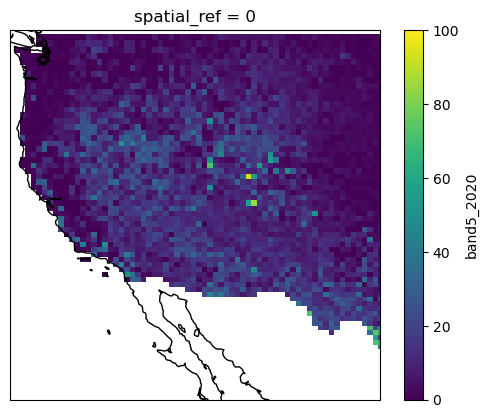

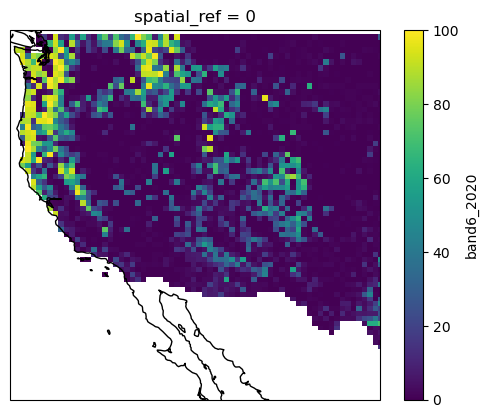

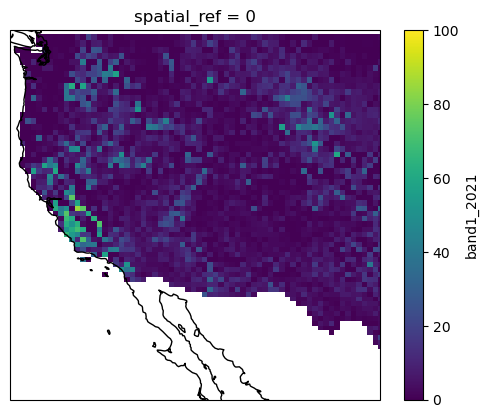

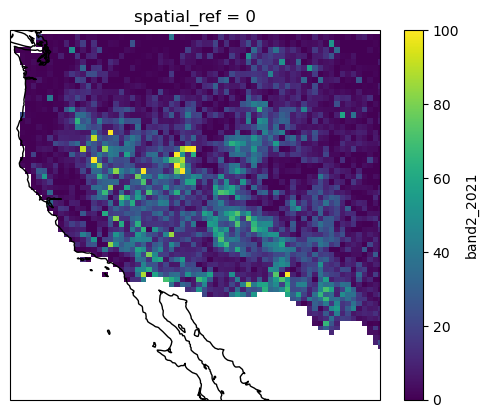

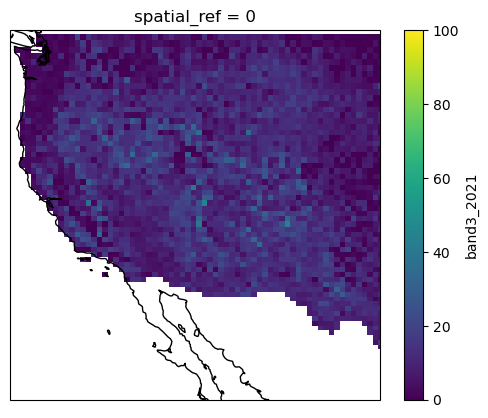

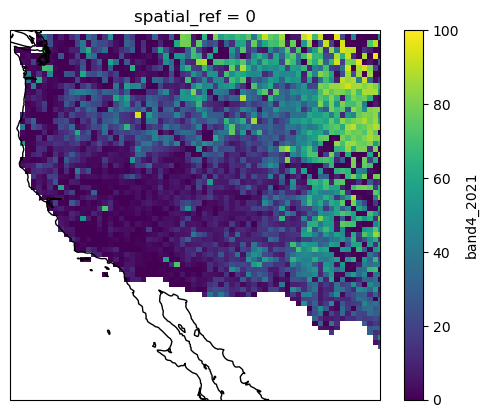

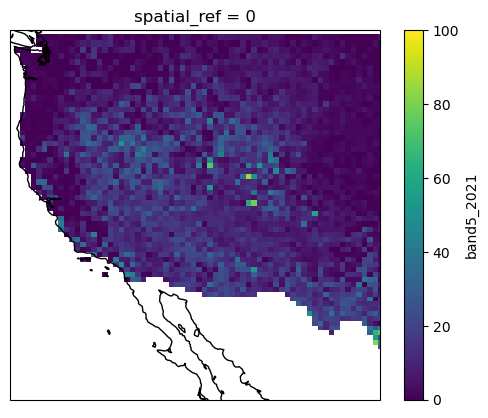

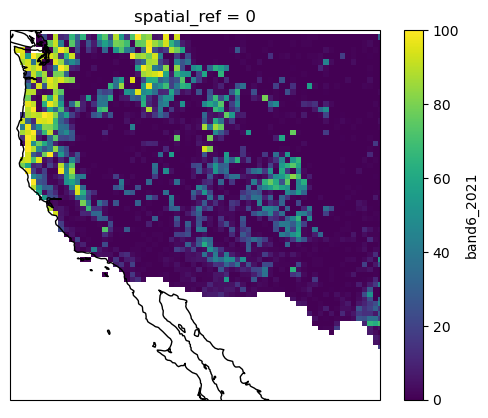

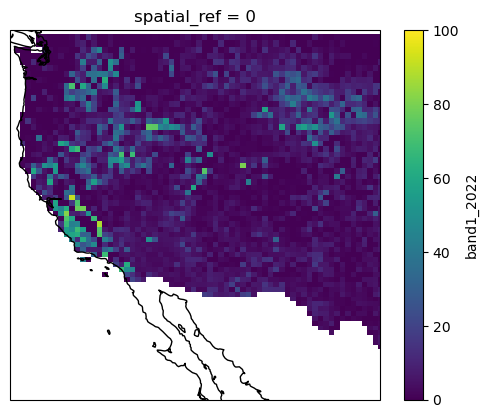

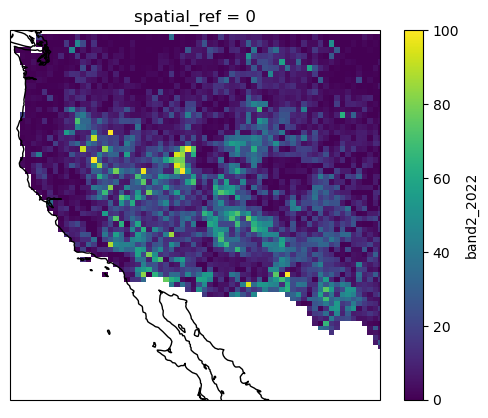

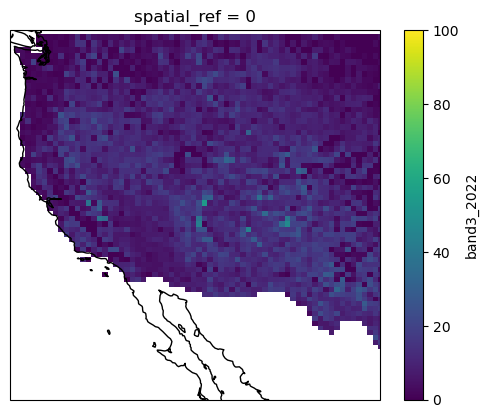

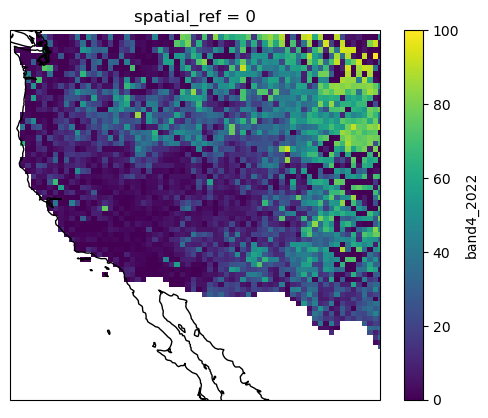

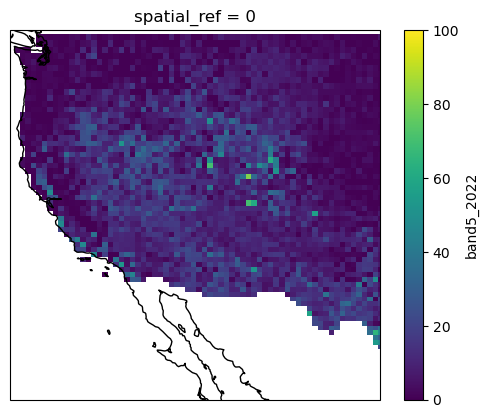

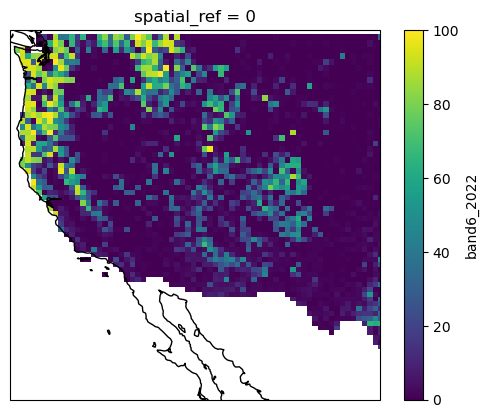

In [4]:
# Define the range of years and band numbers
years = range(2015, 2023)  # 2023 is not included, so it goes up to 2022
band_numbers = range(1, 7)  # 7 is not included, so it goes up to 6

for year in years:
    for band in band_numbers:
        base_dir = os.path.join(data_dir, rangeland_dir)
        file=f"{year}_band{band}.nc"
        _ds = xr.open_dataset(f"{base_dir}/{file}")
        _ds = _ds.rename({'__xarray_dataarray_variable__': 'landcover_fraction'})
        _ds['landcover_fraction'] = _ds['landcover_fraction'].where(_ds['landcover_fraction'] <= 100, np.nan)
        _ds = _ds.rio.write_crs("epsg:4326")
        
        var_name = f"band{band}_{year}"
        ds_SMAPL3_coord_template[var_name] = _ds['landcover_fraction']
        
        fig, ax = plt.subplots(subplot_kw={'projection': projection})
        conus_extent = [-125, -100, 24.5, 49.5]
        # conus_extent = [-125, -66.5, 24.5, 49.5]
        ds_SMAPL3_coord_template[var_name].plot(ax=ax, transform=projection, vmin=0, vmax=100)
        ax.set_extent(conus_extent, crs=ccrs.PlateCarree())
        ax.coastlines()
        plt.show()


In [5]:
EASE_column_index_xarray = xr.DataArray(EASE_column_index_expanded, dims=('y', 'x'), coords={'y': ds_SMAPL3_coord_template['y'], 'x': ds_SMAPL3_coord_template['x']})
ds_SMAPL3_coord_template['EASE_column_index'] = EASE_column_index_xarray

EASE_row_index_xarray = xr.DataArray(EASE_row_index_expanded, dims=('y', 'x'), coords={'y': ds_SMAPL3_coord_template['y'], 'x': ds_SMAPL3_coord_template['x']})
ds_SMAPL3_coord_template['EASE_row_index'] = EASE_row_index_xarray

In [6]:
list_varnames = []
for year in years:
    for band in band_numbers:
        list_varnames.append(f"band{band}_{year}")
new_variable_names = ['EASE_column_index', 'EASE_row_index'] + list_varnames
df = ds_SMAPL3_coord_template[new_variable_names].to_dataframe()
df.index.names = ['latitude', 'longitude']
df.drop(columns="spatial_ref", inplace=True)
df

EASE_column_index  EASE_row_index  band1_2015  \
latitude   longitude                                                    
 83.631973 -179.813278                  0               0         NaN   
           -179.439835                  1               0         NaN   
           -179.066391                  2               0         NaN   
           -178.692947                  3               0         NaN   
           -178.319504                  4               0         NaN   
...                                   ...             ...         ...   
-83.631973  178.319504                959             405         NaN   
            178.692947                960             405         NaN   
            179.066391                961             405         NaN   
            179.439835                962             405         NaN   
            179.813278                963             405         NaN   

                        band2_2015  band3_2015  band4_2015  band5_2015  \
latitude   longitude                                                     
 83.631973 -179.813278         NaN         NaN         NaN         NaN   
           -179.439835         NaN         NaN         NaN         NaN   
           -179.066391         NaN         NaN         NaN         NaN   
           -178.692947         NaN         NaN         NaN         NaN   
           -178.319504         NaN         NaN         NaN         NaN   
...                            ...         ...         ...         ...   
-83.631973  178.319504         NaN         NaN         NaN         NaN   
            178.692947         NaN         NaN         NaN         NaN   
            179.066391         NaN         NaN         NaN         NaN   
            179.439835         NaN         NaN         NaN         NaN   
            179.813278         NaN         NaN         NaN         NaN   

                        band6_2015  band1_2016  band2_2016  ...  band3_2021  \
latitude   longitude                                        ...               
 83.631973 -179.813278         NaN         NaN         NaN  ...         NaN   
           -179.439835         NaN         NaN         NaN  ...         NaN   
           -179.066391         NaN         NaN         NaN  ...         NaN   
           -178.692947         NaN         NaN         NaN  ...         NaN   
           -178.319504         NaN         NaN         NaN  ...         NaN   
...                            ...         ...         ...  ...         ...   
-83.631973  178.319504         NaN         NaN         NaN  ...         NaN   
            178.692947         NaN         NaN         NaN  ...         NaN   
            179.066391         NaN         NaN         NaN  ...         NaN   
            179.439835         NaN         NaN         NaN  ...         NaN   
            179.813278         NaN         NaN         NaN  ...         NaN   

                        band4_2021  band5_2021  band6_2021  band1_2022  \
latitude   longitude                                                     
 83.631973 -179.813278         NaN         NaN         NaN         NaN   
           -179.439835         NaN         NaN         NaN         NaN   
           -179.066391         NaN         NaN         NaN         NaN   
           -178.692947         NaN         NaN         NaN         NaN   
           -178.319504         NaN         NaN         NaN         NaN   
...                            ...         ...         ...         ...   
-83.631973  178.319504         NaN         NaN         NaN         NaN   
            178.692947         NaN         NaN         NaN         NaN   
            179.066391         NaN         NaN         NaN         NaN   
            179.439835         NaN         NaN         NaN         NaN   
            179.813278         NaN         NaN         NaN         NaN   

                        band2_2022  band3_2022  band4_2022  band5_2022  \
latitude   longitude                          

In [9]:
# Assuming `data` is your DataFrame with the columns as described

# Melt the DataFrame to go from wide to long format
melted_df = df.melt(id_vars=["EASE_column_index","EASE_row_index"], value_name="value")
melted_df["band"] = melted_df["variable"].apply(lambda x: int(x.split('_')[0].replace("band", "")))
melted_df["year"] = melted_df["variable"].apply(lambda x: x.split('_')[1])

In [12]:
# Define a dictionary mapping band numbers to their descriptions
band_descriptions = {
    1: "Annual forb and grass",
    2: "Bare ground",
    3: "Litter",
    4: "Perennial forb and grass",
    5: "Shrub",
    6: "Tree"
}

# Create a new column with the band descriptions
melted_df["functional_group"] = melted_df["band"].map(band_descriptions)

,EASE_column_index,EASE_row_index,variable,value,band,year,functional_group
0,0,0,band1_2015,NaN,1,2015,Annual forb and grass
1,1,0,band1_2015,NaN,1,2015,Annual forb and grass
2,2,0,band1_2015,NaN,1,2015,Annual forb and grass
3,3,0,band1_2015,NaN,1,2015,Annual forb and grass
4,4,0,band1_2015,NaN,1,2015,Annual forb and grass
...,...,...,...,...,...,...,...
18786427,959,405,band6_2022,NaN,6,2022,Tree
18786428,960,405,band6_2022,NaN,6,2022,Tree
18786429,961,405,band6_2022,NaN,6,2022,Tree
18786430,962,405,band6_2022,NaN,6,2022,Tree


In [14]:
melted_df.rename(columns={"value": "landcover_percent"}, inplace=True)
melted_df.drop(columns="variable",inplace=True)
melted_df

,EASE_column_index,EASE_row_index,landcover_percent,band,year,functional_group
0,0,0,NaN,1,2015,Annual forb and grass
1,1,0,NaN,1,2015,Annual forb and grass
2,2,0,NaN,1,2015,Annual forb and grass
3,3,0,NaN,1,2015,Annual forb and grass
4,4,0,NaN,1,2015,Annual forb and grass
...,...,...,...,...,...,...
18786427,959,405,NaN,6,2022,Tree
18786428,960,405,NaN,6,2022,Tree
18786429,961,405,NaN,6,2022,Tree
18786430,962,405,NaN,6,2022,Tree


In [18]:
out_df = pd.merge(df[["EASE_column_index", "EASE_row_index"]], melted_df, on=["EASE_column_index", "EASE_row_index"], how='outer')
out_df

,EASE_column_index,EASE_row_index,landcover_percent,band,year,functional_group
0,0,0,NaN,1,2015,Annual forb and grass
1,0,0,NaN,2,2015,Bare ground
2,0,0,NaN,3,2015,Litter
3,0,0,NaN,4,2015,Perennial forb and grass
4,0,0,NaN,5,2015,Shrub
...,...,...,...,...,...,...
18786427,963,405,NaN,2,2022,Bare ground
18786428,963,405,NaN,3,2022,Litter
18786429,963,405,NaN,4,2022,Perennial forb and grass
18786430,963,405,NaN,5,2022,Shrub


# Output

In [19]:
filename = r"/home/raraki/waves/projects/smap-drydown/data/datarods/anc_info_rangeland.csv"
out_df.to_csv(filename)

In [39]:
import pandas as pd
data = pd.read_csv(filename)
data.head()

,latitude,longitude,EASE_column_index,EASE_row_index,band1_2015,band2_2015,band3_2015,band4_2015,band5_2015,band6_2015,...,band4_2021,band5_2021,band6_2021,band1_2022,band2_2022,band3_2022,band4_2022,band5_2022,band6_2022,spatial_ref
0,83.63197,-179.81328,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,83.63197,-179.43983,1,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,83.63197,-179.06639,2,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,83.63197,-178.69295,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,83.63197,-178.31950,4,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


/tmp/ipykernel_1254272/3454353063.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(5,4))


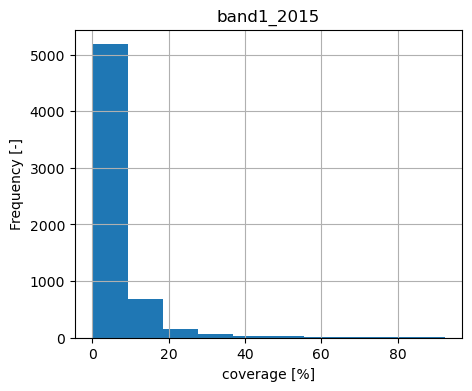

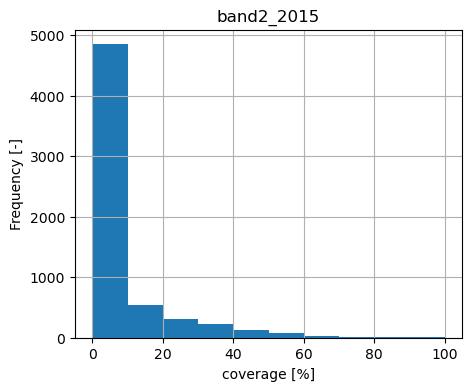

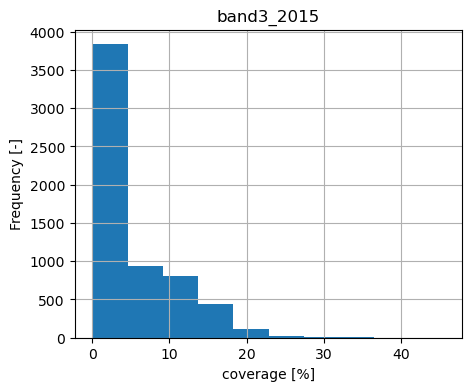

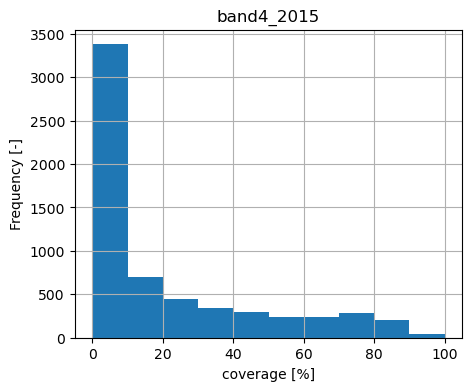

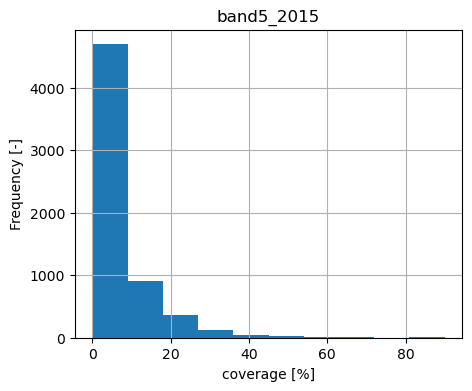

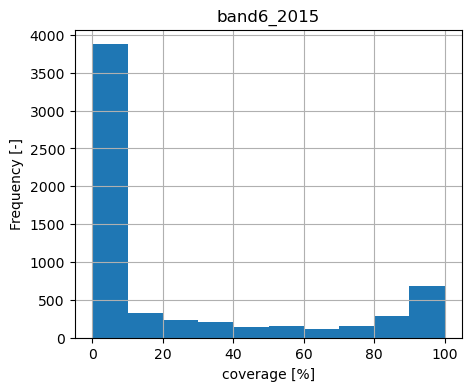

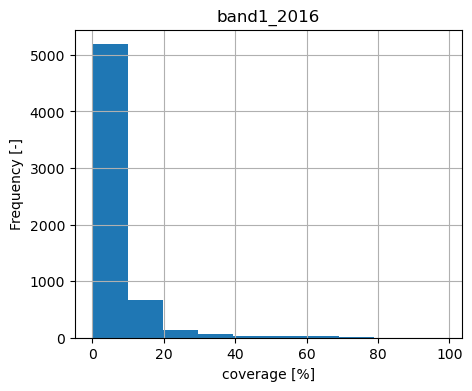

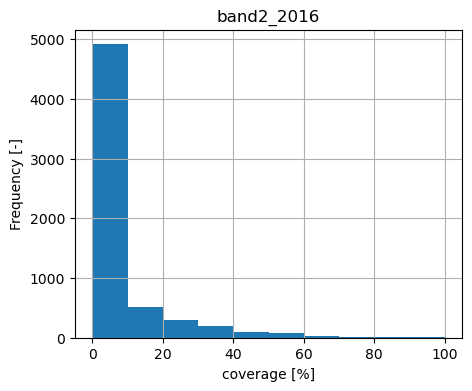

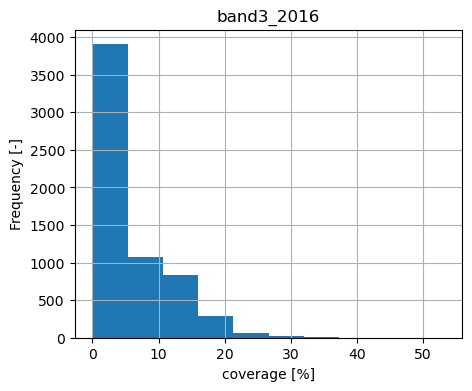

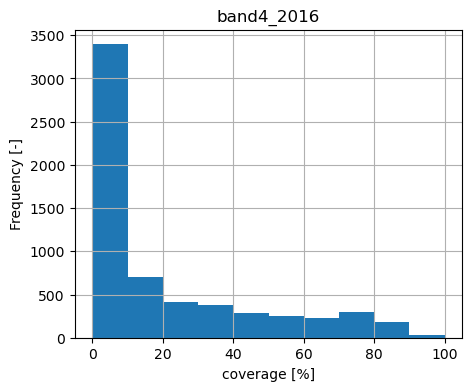

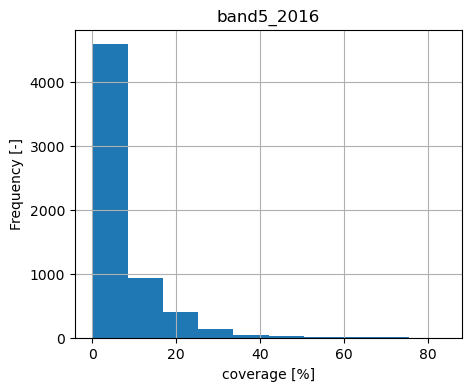

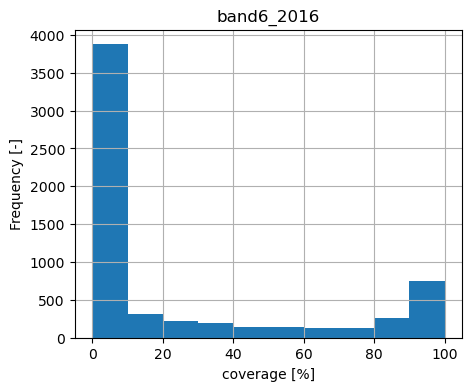

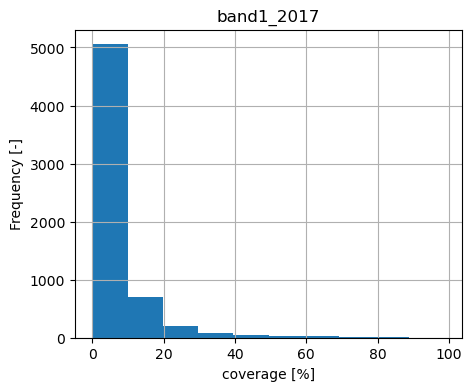

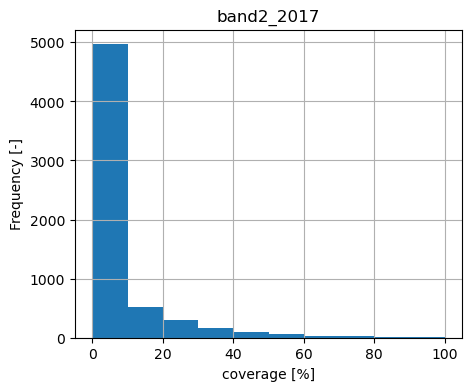

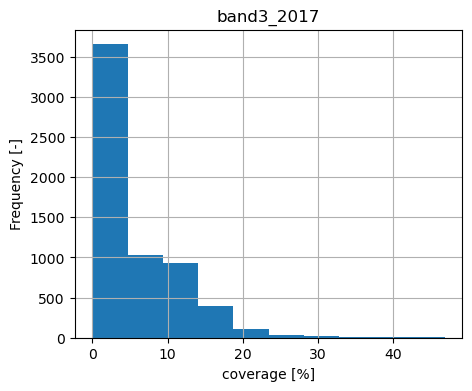

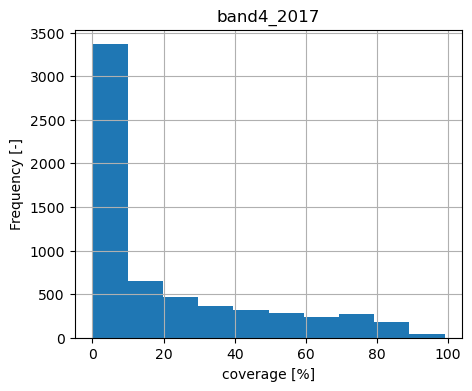

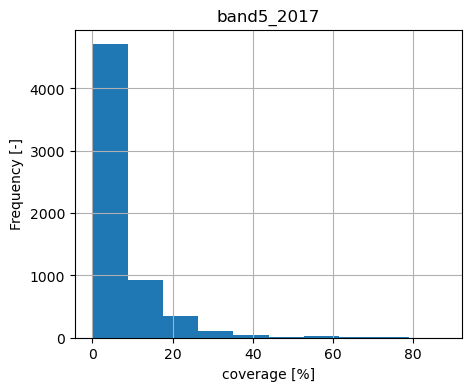

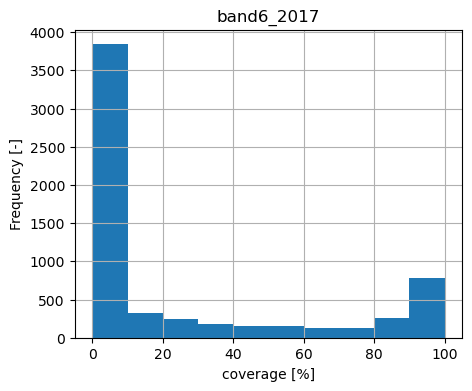

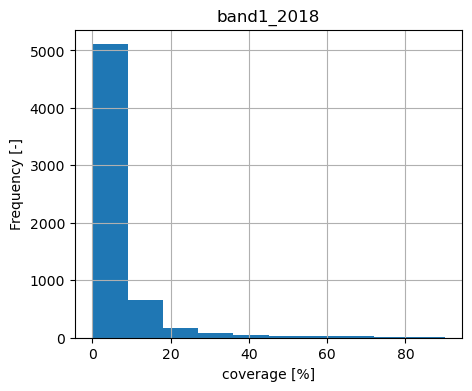

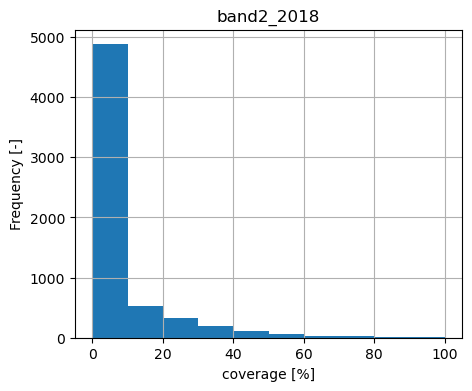

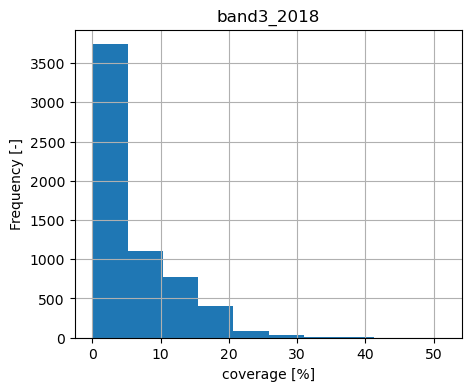

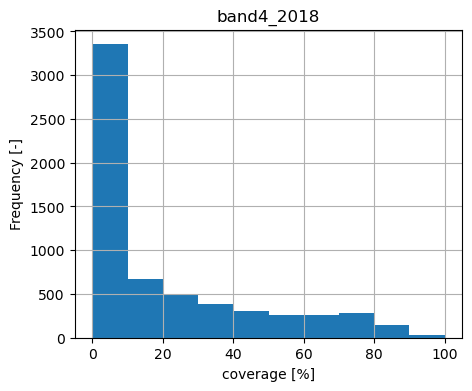

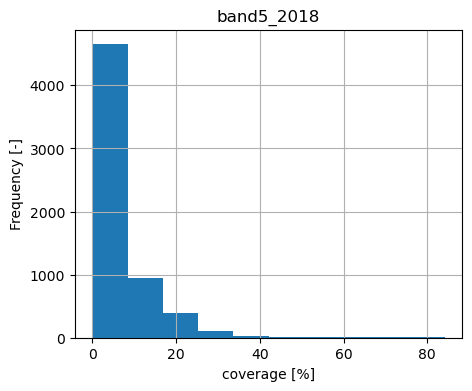

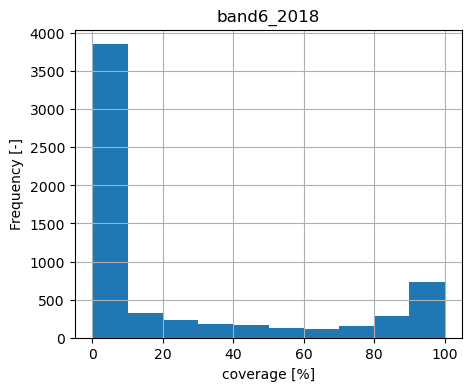

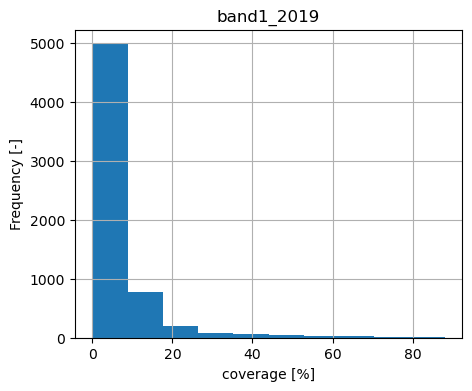

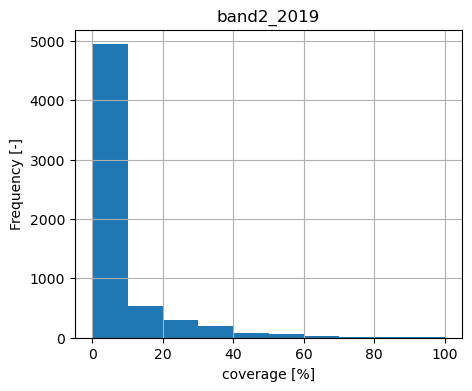

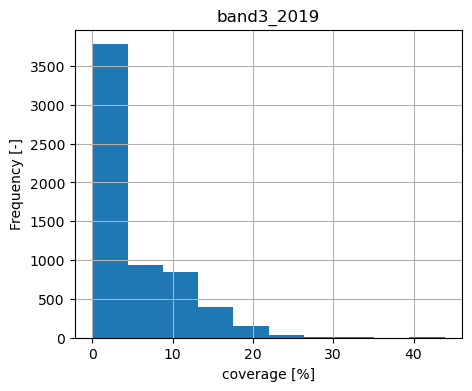

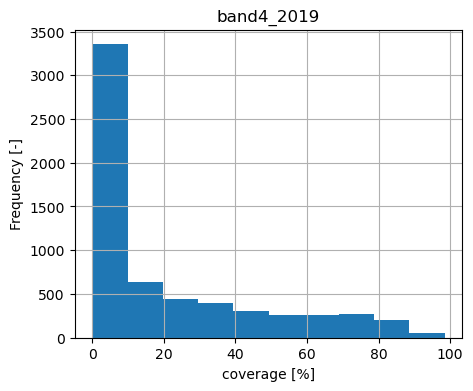

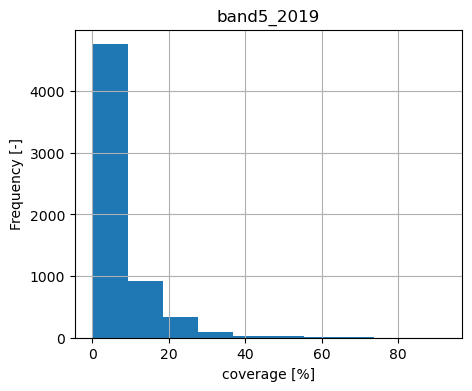

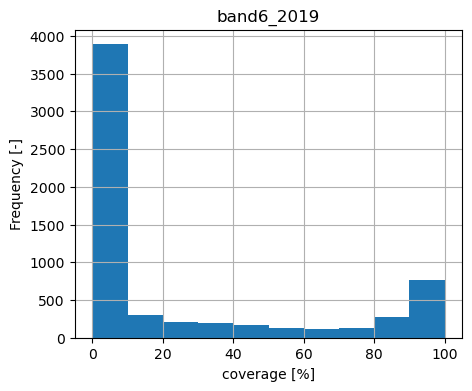

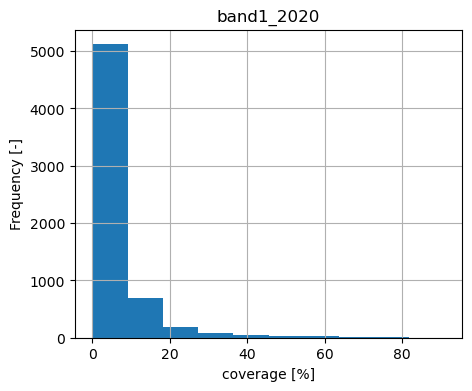

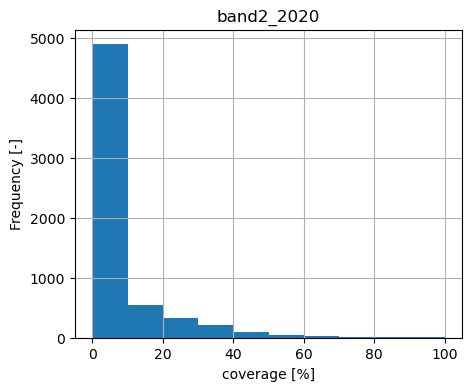

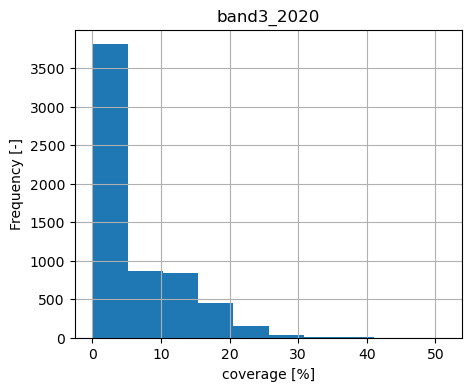

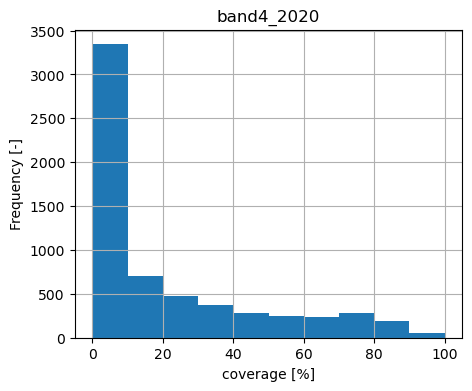

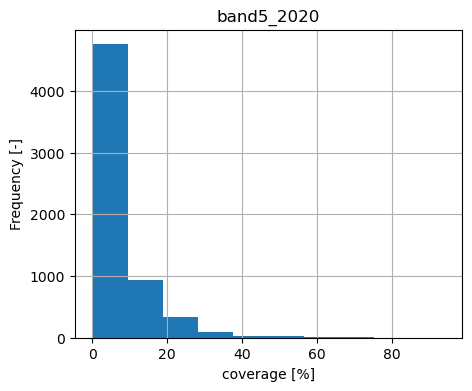

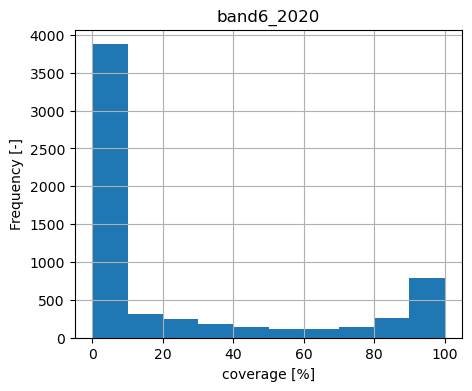

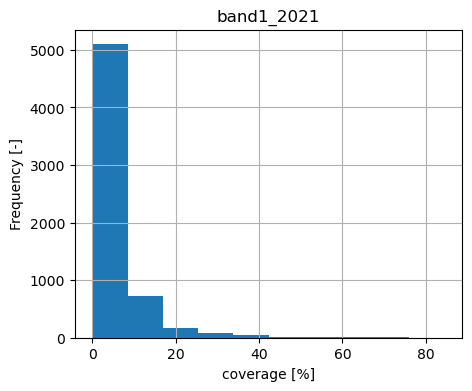

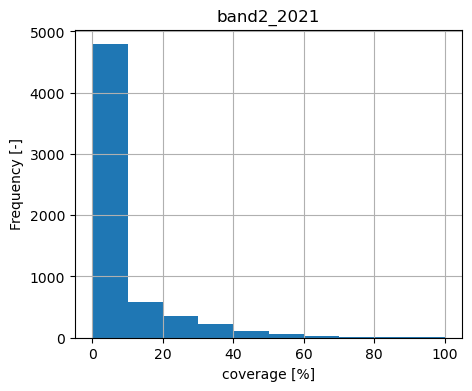

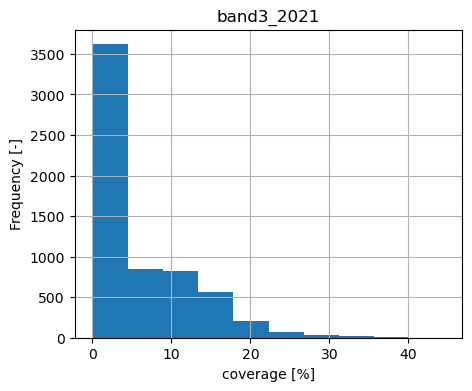

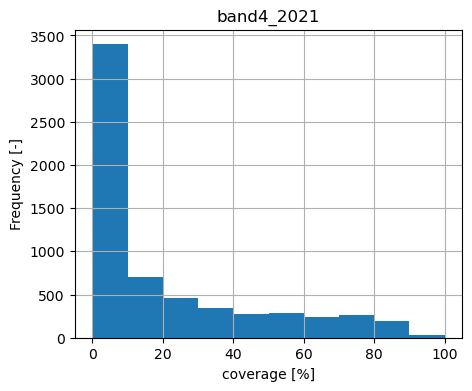

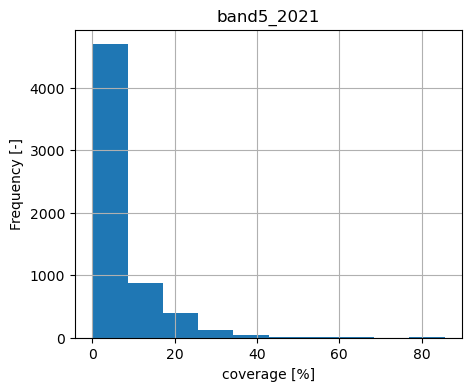

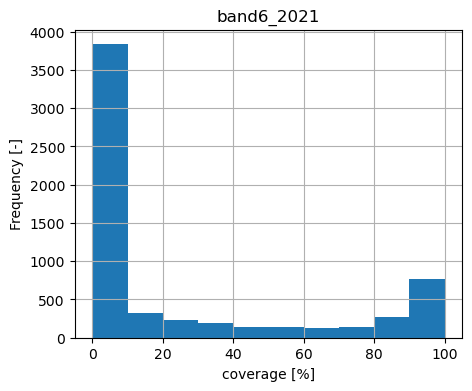

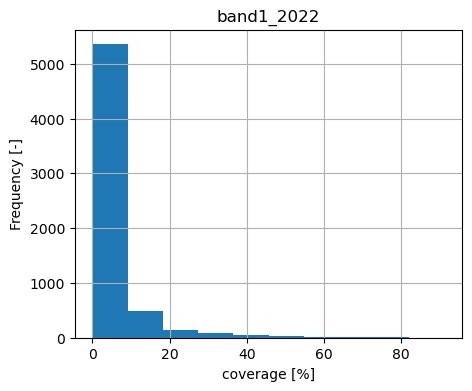

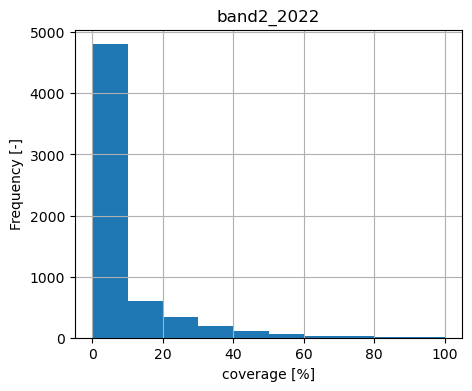

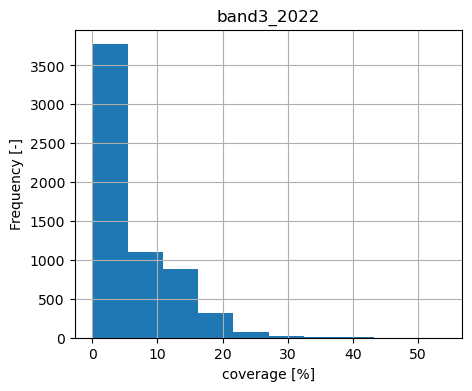

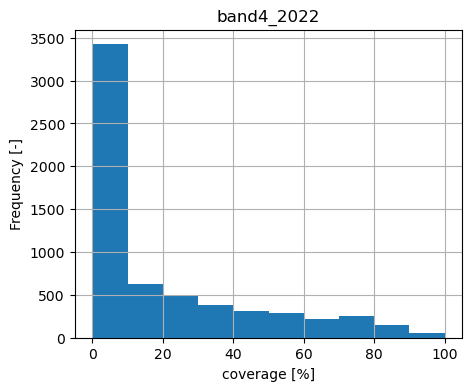

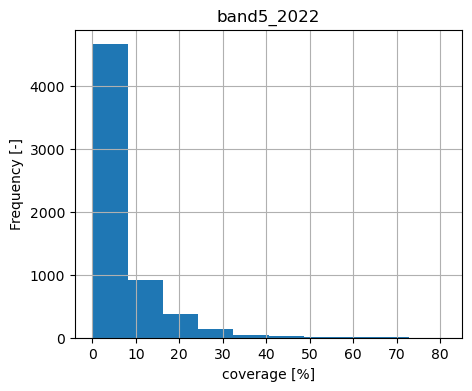

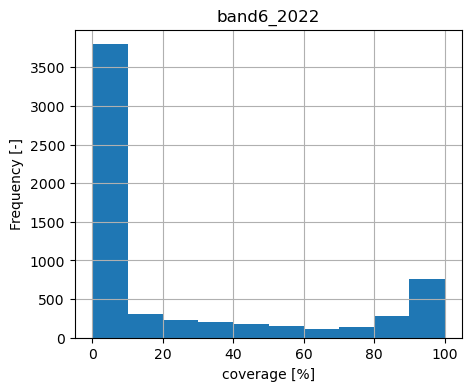

In [52]:
for year in years:
    for band in band_numbers:
        fig, ax = plt.subplots(figsize=(5,4))
        varname = f'band{band}_{year}'
        data[varname].hist(ax=ax)
        ax.set_title(varname)
        ax.set_xlabel('coverage [%]')
        ax.set_ylabel('Frequency [-]')